# 파트 10
----
각종 탐구적 분석 과정에서 나온 결과물들이 들어있다. 단순 가격의 평균값, 중앙값과 다른 변수들과의 비선형성 관계를 확인 할 수 있다. 또한 가격변화율에 대한 회귀분석을 해 보았으나, 유의미한 예측수치가 나오지 않는 것을 확일 할 수 있다.

In [99]:
%matplotlib inline
from __future__ import division
from __future__ import print_function
import sklearn.preprocessing
import sklearn.feature_selection
from sklearn.decomposition import PCA

In [100]:
# setting the folder path and read in data
path = 'raw_data\\'
df_original = pd.read_csv(path + '07_pop_estate_year.csv', encoding='utf-8')

In [101]:
# changing the column order
df_columns = [u'year', u'area_code', u'trade_vol',
              u'mov_vol', u'head_ratio', u'head_male_ratio', u'head_age', u'multi_ratio', u'ppl_per_house',
              u'mov_ppl_vol', u'mov_male_ratio', u'pop_change_ratio', u'built',
              u'r_1', u'r_2', u'r_3', u'r_5', u'r_4', u'r_6', u'r_9',
              u'ppa_median', u'ppa_mean', u'ppa_median_log', u'ppa_change_pre', u'ppa_change_post']

df = df_original[df_columns]

In [102]:
years = range(2006, 2015)

In [103]:
df.head()

,year,area_code,trade_vol,mov_vol,head_ratio,head_male_ratio,head_age,multi_ratio,ppl_per_house,mov_ppl_vol,...,r_3,r_5,r_4,r_6,r_9,ppa_median,ppa_mean,ppa_median_log,ppa_change_pre,ppa_change_post
0,2006,11110,726.0,53130.0,0.008752,-0.003721,40.901875,0.342594,-0.051722,90066.0,...,-0.004197,0.002033,0.009825,-0.000960,-0.007642,339.575046,369.636029,5.827695,1.196688,NaN
1,2006,11140,1010.0,42733.0,0.017223,0.008224,41.031013,0.330003,0.001076,70768.0,...,-0.017200,0.001287,0.003908,-0.000936,-0.006201,462.128795,457.123602,6.135844,1.045736,NaN
2,2006,11170,2415.0,83396.0,0.032196,0.016316,40.849627,0.349069,0.012459,142123.0,...,0.003537,-0.000096,-0.000288,-0.001487,-0.019018,564.971751,602.588603,6.336776,1.198596,NaN
3,2006,11200,4204.0,102922.0,-0.008550,-0.013586,39.905427,0.374400,-0.052758,182908.0,...,-0.001059,0.000933,0.002857,-0.000641,-0.010270,466.329966,478.887059,6.144893,1.161458,NaN
4,2006,11215,2658.0,125386.0,0.017402,0.001044,38.791690,0.380864,-0.024947,225942.0,...,0.035881,0.001459,0.005559,-0.000949,-0.007082,501.504514,512.469919,6.217613,1.179194,NaN


In [104]:
df = df.set_index('area_code')

In [105]:
# just a helper list
ppa_columns = ['ppa_mean', 'ppa_median', 'ppa_median_log', 'ppa_change_pre', 'ppa_change_post']

In [106]:
# custom class containing a fitted linear regression model,
# parameters, targets, and area codes for easy access
class Custom_df:
    def __init__(self, df, target, do_pca, do_f_reg):
        # create a scaler for a given dataframe
        self.dfX = df.drop(ppa_columns, axis=1)
        self.dfy = df[ppa_columns]
        
        self.df_scaler = Scaler(self.dfX)
        
        # create a normalized copy
        self.dfX = pd.DataFrame(self.df_scaler.X.transform(self.dfX), index=self.dfX.index, columns=self.dfX.columns)
        
        # patching things up
        if 0 in self.dfX.index:
            self.dfX = self.dfX.reset_index(0)
            self.dfy = self.dfy.reset_index(0)
        
        self.dfX, self.dfy, self.result = optimize_fit(self.dfX, self.dfy, target, do_pca, do_f_reg)
        
        self.area_codes = df.index.unique()

In [107]:
# custom scaler object for easier use
class Scaler:
    def __init__(self, dfX):
        self.X = sk.preprocessing.StandardScaler()
        self.X.fit(dfX)

In [108]:
# this is an automated linear regression method
# first throws out variables with high F probability (greater than threshold)
# then throws out variables that aren't statistically significant (also greater than threshold)
def optimize_fit(dfX, dfy, target, do_pca=False, do_f_reg=False):
    # threshold to pass for the variables to keep
    threshold = 0.01
    
    # perform PCA
    if do_pca:
        pca = PCA()
        pca.fit(dfX)
        feature_size = pca.explained_variance_ratio_[~(pca.explained_variance_ratio_.cumsum() >= (1 - threshold))].size
        pca = PCA(n_components=feature_size)
        pca.fit(dfX)
        dfX = pd.DataFrame(pca.fit_transform(dfX), index=dfX.index)    
    
    dfX = sm.add_constant(dfX)
    
    # perform F-regression
    if do_f_reg:
        F, F_p = sk.feature_selection.f_regression(dfX, dfy[target])
        f_reg = pd.DataFrame(F_p, index=dfX.columns, columns=['F_p'])
        dfX = dfX.drop(f_reg.loc[f_reg.F_p > threshold].index, axis=1)
    
    # drop statistically not significant variables one by one
    while True:
        model = sm.OLS(dfy[target], dfX)
        result = model.fit()
        not_significant = result.pvalues[result.pvalues > threshold]
        
        if not_significant.size == 0:
            break
        else:
            dfX = dfX.drop(not_significant.sort_values().index[0], axis=1)

    return dfX, dfy, result

In [109]:
# custom plotting function
def plot_results(df_custom, target):
    # plot predicted price vs actual price
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.scatter(df_custom.result.predict(df_custom.dfX), df_custom.dfy[target], c=df_custom.dfy.index, cmap='prism')
    plt.xlabel('Predicted ' + target)
    plt.ylabel('Actual ' + target)
    
    plt.subplot(1, 2, 2)
    sns.distplot(df_custom.result.predict(df_custom.dfX) - df_custom.dfy[target])
    plt.xlabel('Price difference distribution of ' + target)
    
    if target[-3:] == 'log':
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plt.scatter(np.exp(df_custom.result.predict(df_custom.dfX)),
                    np.exp(df_custom.dfy[target]),
                    c=colors, cmap='prism')    
        plt.xlabel('Predicted ' + target[-3:])
        plt.ylabel('Actual ' + target[-3:])
        
        plt.subplot(1, 2, 2)
        sns.distplot(np.exp(df_custom.result.predict(df_custom.dfX)) - np.exp(df_custom.dfy[target]))
        plt.xlabel('Price difference distribution of ' + target[-3:])

In [110]:
target = 'ppa_mean'
do_pca = False
do_f_reg = True

                            OLS Regression Results                            
Dep. Variable:               ppa_mean   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     287.6
Date:                Wed, 12 Jul 2017   Prob (F-statistic):               0.00
Time:                        19:57:07   Log-Likelihood:                -13794.
No. Observations:                2274   AIC:                         2.761e+04
Df Residuals:                    2262   BIC:                         2.768e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const         212.6154      2.192     96.995      

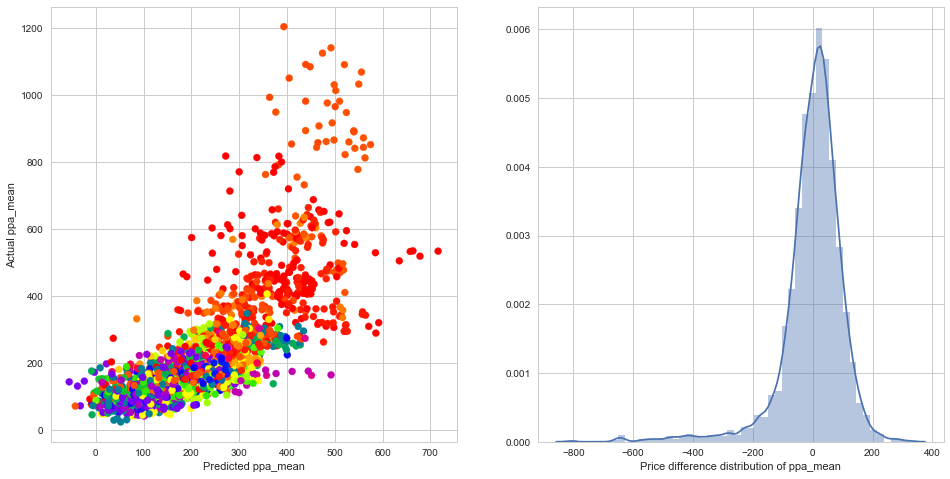

In [111]:
# we try a regression analysis on mean prices
df_custom = Custom_df(df, target, do_pca, do_f_reg)
print(df_custom.result.summary())
plot_results(df_custom, target)

                            OLS Regression Results                            
Dep. Variable:             ppa_median   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     267.0
Date:                Wed, 12 Jul 2017   Prob (F-statistic):               0.00
Time:                        19:57:08   Log-Likelihood:                -13703.
No. Observations:                2274   AIC:                         2.743e+04
Df Residuals:                    2261   BIC:                         2.751e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const         205.9041      2.106     97.749      

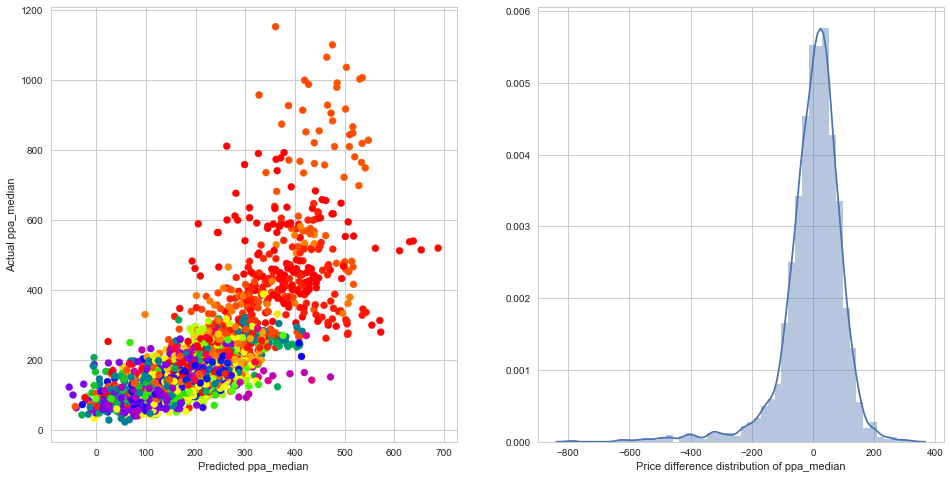

In [112]:
# we try a different approach and do the same on median prices
target = 'ppa_median'
df_custom = Custom_df(df, target, do_pca, do_f_reg)
print(df_custom.result.summary())
plot_results(df_custom, target)

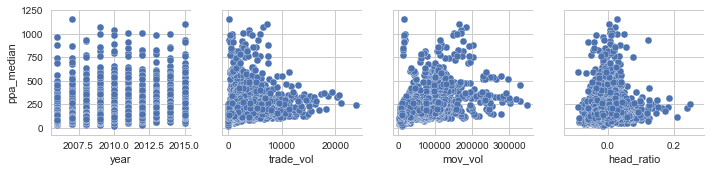

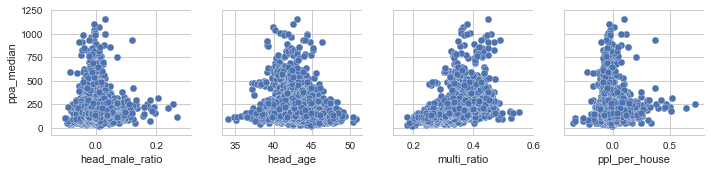

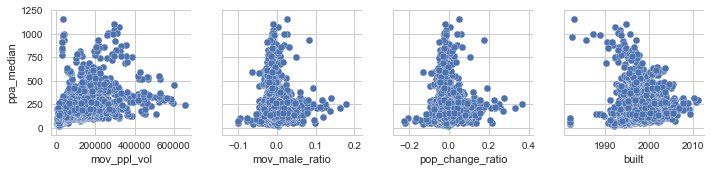

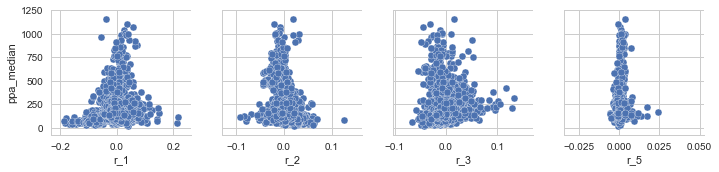

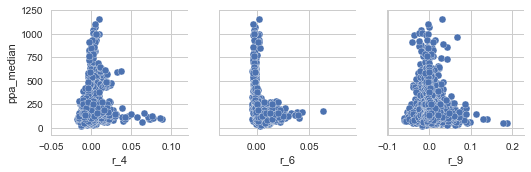

In [113]:
# some plotting to diagnose the problem
# there doesn't seem to be much of a linear relation between
# median prices and other parameters
x_vars = [u'year', u'trade_vol',
          u'mov_vol', u'head_ratio', u'head_male_ratio', u'head_age', u'multi_ratio', u'ppl_per_house',
          u'mov_ppl_vol', u'mov_male_ratio', u'pop_change_ratio', u'built',
          u'r_1', u'r_2', u'r_3', u'r_5', u'r_4', u'r_6', u'r_9',]

n = 4
m = len(x_vars) // n
for i in range(n + 1):
    sns.pairplot(df.drop(['ppa_change_pre', 'ppa_change_post'], axis=1),
                 x_vars=x_vars[m * i:m * (i + 1)],
                 y_vars=['ppa_median'])

                            OLS Regression Results                            
Dep. Variable:         ppa_change_pre   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     30.25
Date:                Wed, 12 Jul 2017   Prob (F-statistic):           1.13e-13
Time:                        19:57:11   Log-Likelihood:                 440.70
No. Observations:                2044   AIC:                            -875.4
Df Residuals:                    2041   BIC:                            -858.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const           1.0828      0.004    250.805      

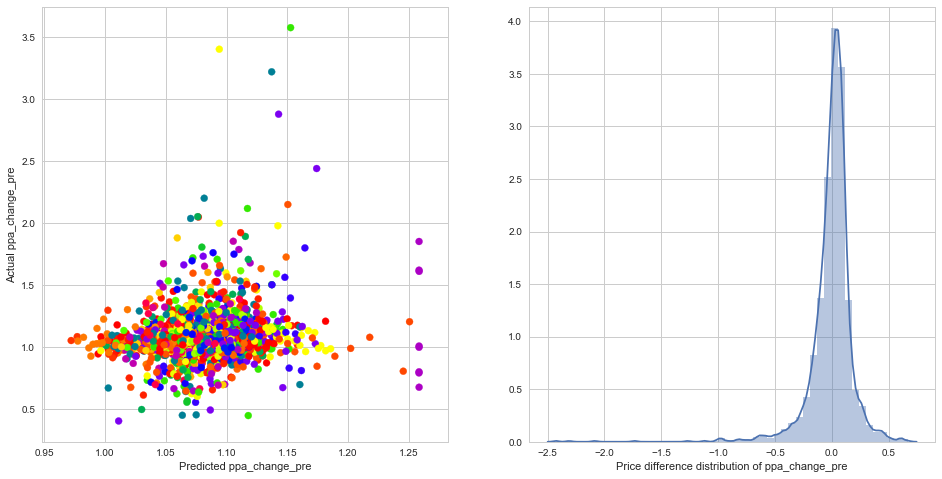

In [114]:
# we try a different approach and do the same on median prices
target = 'ppa_change_pre'
df_custom = Custom_df(df.loc[~df.ppa_change_pre.isnull()], target, do_pca, do_f_reg)
print(df_custom.result.summary())
plot_results(df_custom, target)

                            OLS Regression Results                            
Dep. Variable:        ppa_change_post   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     38.93
Date:                Wed, 12 Jul 2017   Prob (F-statistic):           2.56e-17
Time:                        19:57:13   Log-Likelihood:                 449.11
No. Observations:                2044   AIC:                            -892.2
Df Residuals:                    2041   BIC:                            -875.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.0828      0.004    251.838      0.0

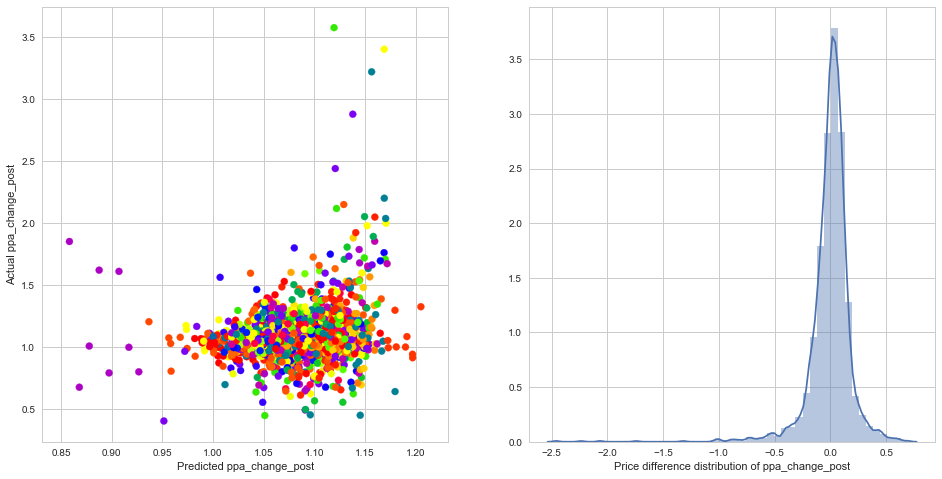

In [116]:
# we try a different approach and do the same on median prices
target = 'ppa_change_post'
df_custom = Custom_df(df.loc[~df.ppa_change_post.isnull()], target, do_pca, do_f_reg)
print(df_custom.result.summary())
plot_results(df_custom, target)